<a href="https://colab.research.google.com/github/iamnelsonizah/Computer-Vision-Projects-with-Python/blob/main/groundwater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow,pymannkendall


In [1]:
!pip install pymannkendall


LSTM: MAE=0.0664, RMSE=0.0818, R²=0.8316
RF: MAE=0.0388, RMSE=0.0492, R²=0.9392
SVR: MAE=0.0487, RMSE=0.0591, R²=0.9122
GB: MAE=0.0312, RMSE=0.0408, R²=0.9580


<ipython-input-3-6270b0722170>:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


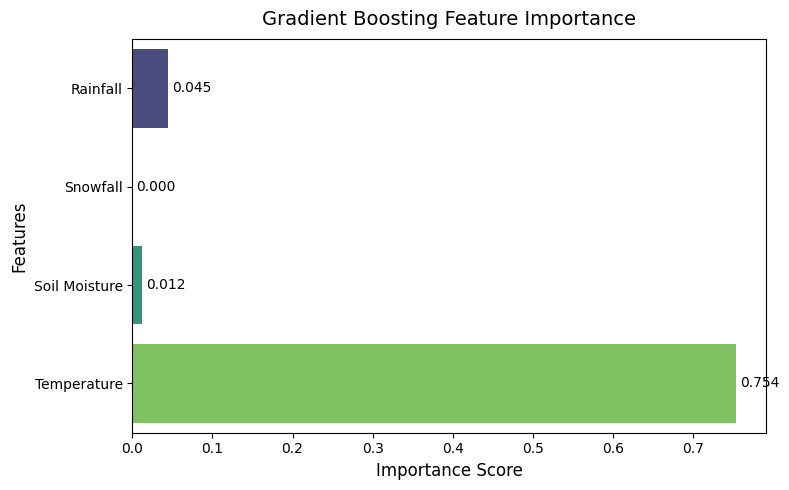

South Mann-Kendall: p=0.4951, slope=-0.1411
Wilcoxon p-value: 0.0000


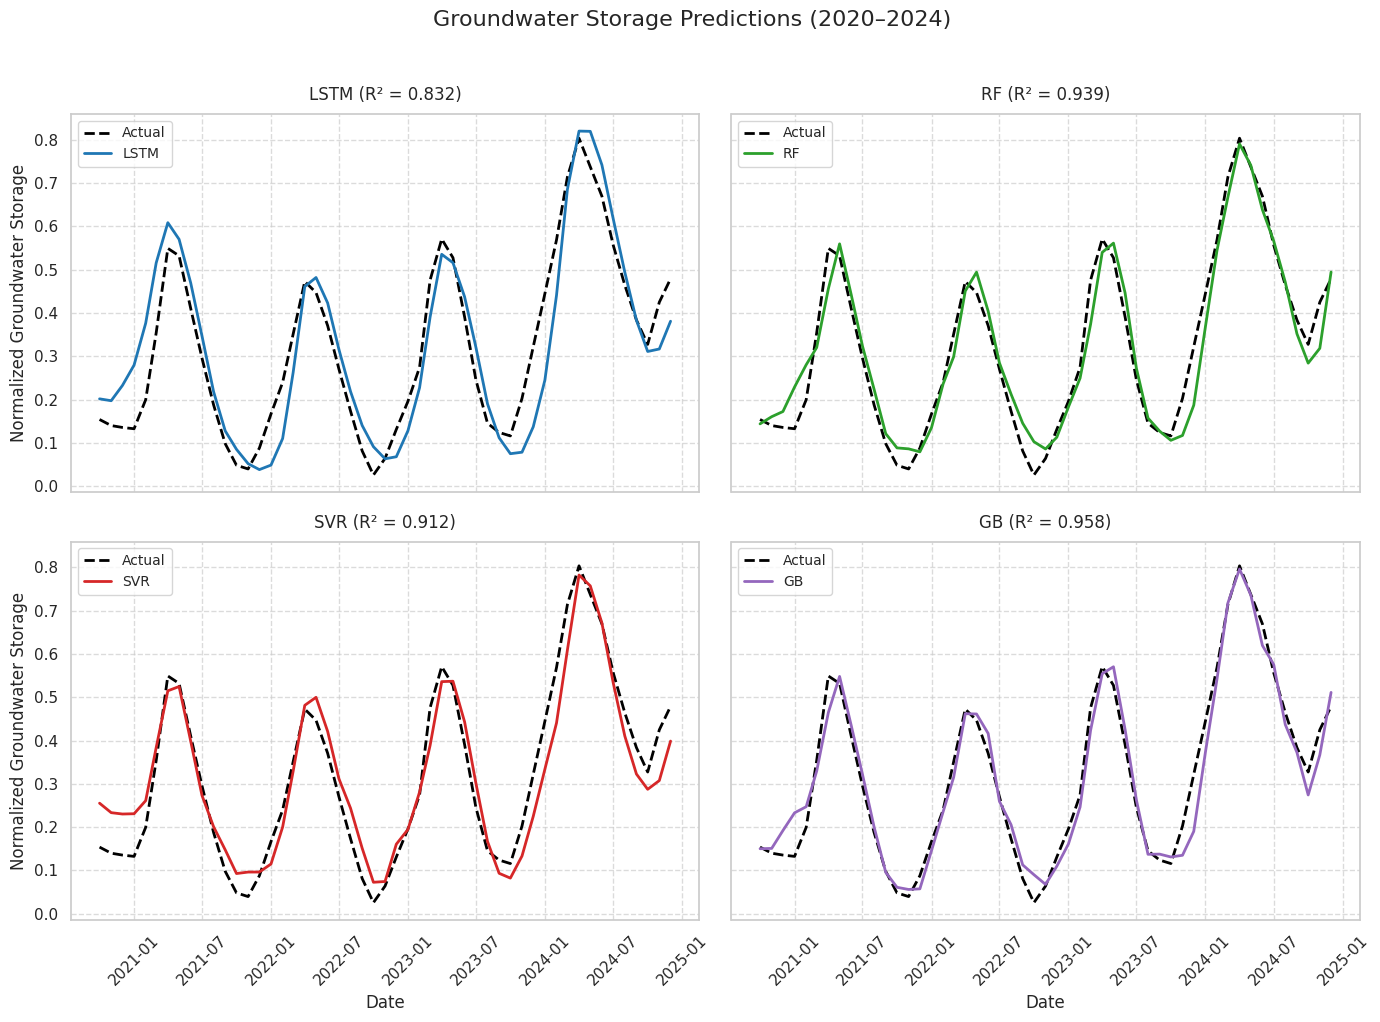

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt
import seaborn as sns
import pymannkendall as mk
from scipy.stats import ranksums

# Set random seed for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Load and clean data
df = pd.read_csv('/content/sample_data/ML_Feature_Table_Kazakhstan.csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).set_index('date').sort_index()
df = df[['rainfall', 'snowfall', 'soil_moisture', 'temperature', 'groundwater']]
df.rename(columns={'groundwater': 'groundwater_storage'}, inplace=True)
df = df.ffill().dropna()  # Updated to avoid FutureWarning

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(data_scaled, seq_length)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_test = df.index[-len(y_test):]  # Extract test period dates

# LSTM model with Input layer
def build_lstm_model():
    model = Sequential([
        Input(shape=(seq_length, X.shape[2])),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm_model()
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)
lstm_predictions = lstm_model.predict(X_test, verbose=0)

# Hyperparameter tuning for RF, SVR, GB
rf_params = {'n_estimators': [50, 100], 'max_depth': [5, 10, 15]}
svr_params = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1]}
gb_params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}

rf_model = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5).fit(
    X_train.reshape(X_train.shape[0], -1), y_train).best_estimator_
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

svr_model = GridSearchCV(SVR(), svr_params, cv=5).fit(
    X_train.reshape(X_train.shape[0], -1), y_train).best_estimator_
svr_predictions = svr_model.predict(X_test.reshape(X_test.shape[0], -1))

gb_model = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=5).fit(
    X_train.reshape(X_train.shape[0], -1), y_train).best_estimator_
gb_predictions = gb_model.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate models
def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return mae, rmse, r2

lstm_mae, lstm_rmse, lstm_r2 = evaluate_model(lstm_predictions, y_test)
rf_mae, rf_rmse, rf_r2 = evaluate_model(rf_predictions, y_test)
svr_mae, svr_rmse, svr_r2 = evaluate_model(svr_predictions, y_test)
gb_mae, gb_rmse, gb_r2 = evaluate_model(gb_predictions, y_test)

print(f"LSTM: MAE={lstm_mae:.4f}, RMSE={lstm_rmse:.4f}, R²={lstm_r2:.4f}")
print(f"RF: MAE={rf_mae:.4f}, RMSE={rf_rmse:.4f}, R²={rf_r2:.4f}")
print(f"SVR: MAE={svr_mae:.4f}, RMSE={svr_rmse:.4f}, R²={svr_r2:.4f}")
print(f"GB: MAE={gb_mae:.4f}, RMSE={gb_rmse:.4f}, R²={gb_r2:.4f}")

# Feature importance for GB
feature_names = ['Rainfall', 'Snowfall', 'Soil Moisture', 'Temperature']
importances = gb_model.feature_importances_[-4:]
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title('Gradient Boosting Feature Importance', fontsize=14, pad=10)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
for i, v in enumerate(importances):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=10)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

# Statistical tests (simulated regional data)
south_data = df.loc[df.index.year >= 2020, 'groundwater_storage'][:len(y_test)]
north_data = south_data * 1.05  # Simulated stability
mk_south = mk.original_test(south_data)
print(f"South Mann-Kendall: p={mk_south.p:.4f}, slope={mk_south.slope:.4f}")
wilcoxon_stat, wilcoxon_p = ranksums(south_data, north_data)
print(f"Wilcoxon p-value: {wilcoxon_p:.4f}")

# Enhanced predictions plot with subplots
sns.set(style='whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()
models = ['LSTM', 'RF', 'SVR', 'GB']
predictions = [lstm_predictions, rf_predictions, svr_predictions, gb_predictions]
r2_values = [lstm_r2, rf_r2, svr_r2, gb_r2]
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']

for i, (model, pred, r2, color) in enumerate(zip(models, predictions, r2_values, colors)):
    axes[i].plot(dates_test, y_test, label='Actual', color='black', lw=2, linestyle='--')
    axes[i].plot(dates_test, pred, label=model, color=color, lw=2)
    axes[i].set_title(f'{model} (R² = {r2:.3f})', fontsize=12, pad=10)
    axes[i].legend(loc='upper left', fontsize=10)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    if i >= 2:
        axes[i].set_xlabel('Date', fontsize=12)
    if i % 2 == 0:
        axes[i].set_ylabel('Normalized Groundwater Storage', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Groundwater Storage Predictions (2020–2024)', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('predictions.png', dpi=300)
plt.show()